## Heirarchical Quantum Classifiers [Grant et al.]

Heirarchical Quantum Classifiers[1] presents two different ansatz inspired by tensor networks. Namely, Multi-scale entaglement renormalization ansatz (MERA) and Tree Tensor Network (TTN). Grant et al. train the Parameterize Quantum Circuits (PQCs) from these ansatz for binary classification tasks based on the IRIS and MNIST datasets.

We demonstrate the work present in [1], by classifying the first two classes in IRIS and 0/1 digits from MNIST using MERA and TTN and compare their performance. We also chose to use only $ry$ rotations in the ansatz. All the other details will be the same as [1].

In [7]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import os, csv

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# TODO: mottonen will be changed to its subpackage and the relative path will change
from mottonen import encode_classical_datapoint

seed = 42
np.random.seed(seed)

In [2]:
!export IRIS_URL="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data" && curl $IRIS_URL > iris.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4551  100  4551    0     0  17639      0 --:--:-- --:--:-- --:--:-- 17639


## Data Encoding

### IRIS data set encoding
We standardize the data and make this a binary classification problem.

1. First we will fetch the IRIS dataset
2. Only select the datagrams with labels 1 or 2, and set the label as 1 and -1 respectively.
3. Renormalize the data so that each dimension is only $[0, \frac{\pi}{2}]$
4. Use Mottonen[4] to generate the quantum data encoding circuits using `qubit` encoding, our Mottonen[4] implementation is exactly similar to PyQuil, but adopted for Cirq.

### Standardize the data

In [2]:
class IrisData:
    def __init__(self):
        return
    
    def _get_binary_dataset(self):
        with open('./iris.csv') as csv_file:
            reader = csv.reader(csv_file, delimiter=',')
            rows = list(reader)
            rows.pop()
            data = [row for row in rows if row[4] != 'Iris-virginica']
            for datum in data:
                if datum[4] == 'Iris-setosa':
                    datum[4] = 1.0
                else:
                    datum[4] = -1.0
            data = np.array(data, dtype=np.float32)
            labels = data[:,4]
            data = data[:,:4]
            data = data.reshape(100, 4, 1)
            data = (data-np.min(data))/(np.max(data)-np.min(data))
            data = np.concatenate((np.cos(np.pi*0.5*data), np.sin(np.pi*0.5*data)), axis=2)
            return data, labels
        
    def get_binary_test_train_split(self):
        data, labels = self._get_binary_dataset()
        _data = []
        # only reason for using GridQubit is because the serializer in
        # cirq for converting it into a tensor only works for GridQubits
        # in 'this' cirq release.
        qubits = cirq.GridQubit.rect(1,4)
        for idx in range(data.shape[0]):
            datapoint = data[idx]
            _circuit = cirq.Circuit()
            for i in range(4):
                _circuit.append(encode_classical_datapoint(np.array(datapoint[i][::-1]), [qubits[i]]))
            _data.append(_circuit)
        X_train, X_test, y_train, y_test = train_test_split(_data, labels, test_size=0.1, random_state=seed)
        X_train, X_test = tfq.convert_to_tensor(X_train), tfq.convert_to_tensor(X_test)

        return X_train, X_test, y_train, y_test

In [3]:
iris_data = IrisData()
X_train, X_test, y_train, y_test = iris_data.get_binary_test_train_split()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(90,) (10,) (90,) (10,)


### MNIST data with the first 8 principal components

We standardize the MNIST data set and make this a binary classification problem:

1. Fetch the MNIST dataset and pick datagrams corresponding to digits 0 and 1.
2. Change the 0 and 1 classes to 1 and -1 respectively.
3. Standardize the data and pick the top eight eigenvectors corresponding to their eigenvalue.
4. Renormalize each dimension of the dataset to be in $[0, \frac{\pi}{2}]$
5. Use Mottonen[4] to get the cirq circuits for each datapoint, in `qubit` encoding.

In [65]:
class MNISTData:
    def __init__(self):
        mnist = fetch_openml('mnist_784', version=1, cache=True)
        self.data = mnist['data']
        self.labels = np.array(mnist['target'], dtype=np.int8)
        
    def _get_binary_data_encoding(self):
        labels_zero = self.labels[self.labels==0] + 1
        labels_one = self.labels[self.labels==1] - 2
        binary_labels = np.hstack((labels_zero, labels_one))
        digits_zero = self.data[self.labels==0]
        digits_one = self.data[self.labels==1]
        binary_digits = np.vstack((digits_zero, digits_one))
        
        pca = PCA(n_components=8)
        sc = StandardScaler()
        binary_digits = sc.fit_transform(binary_digits)
        data = pca.fit_transform(binary_digits)
        data = np.expand_dims(data, axis=2)
        data = (data-np.min(data))/(np.max(data)-np.min(data))
        data = np.concatenate((np.cos(np.pi*0.5*data), np.sin(np.pi*0.5*data)), axis=2)
        
        qubits = cirq.GridQubit.rect(1,8)
        _data = []
        for idx in range(data.shape[0]):
            datapoint = data[idx]
            _circuit = cirq.Circuit()
            for i in range(8):
                _circuit.append(encode_classical_datapoint(np.array(datapoint[i][::-1]), [qubits[i]]))
            _data.append(_circuit)
        return _data, binary_labels
        
    def get_binary_test_train_split(self):
        data, labels = self._get_binary_data_encoding()
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=seed)
        return tfq.convert_to_tensor(X_train), tfq.convert_to_tensor(X_test), y_train, y_test

In [15]:
mnist_data = MNISTData()

In [16]:
X_train, X_test, y_train, y_test = mnist_data.get_binary_test_train_split()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14780, 784)
(13302,) (1478,) (13302,) (1478,)


## TTN Model

### Model Definitions

In [109]:
class TTNBinaryClassificationModel():
    def __init__(self):
        iris_data = IrisData()
        mnist_data = MNISTData()
        self.iris_X_train, self.iris_X_test, self.iris_y_train, self.iris_y_test =  iris_data.get_binary_test_train_split()
        self.mnist_X_train, self.mnist_X_test, self.mnist_y_train, self.mnist_y_test = mnist_data.get_binary_test_train_split()
        #self.mnist_X_train = self.mnist_X_train[:100]
        #self.mnist_y_train = self.mnist_y_train[:100]
        return
    
    def _ttn_real_unitary(self, qubits, symbols, reverse=False):
        circuit = cirq.Circuit()
        circuit.append(cirq.ry(symbols[0])(qubits[0]))
        circuit.append(cirq.ry(symbols[1])(qubits[1]))
        if reverse:
            circuit.append(cirq.CNOT(qubits[1], qubits[0]))
        else:
            circuit.append(cirq.CNOT(qubits[0], qubits[1]))
        return circuit
    
    def _ttn_model_iris(self, qubits):
        symbols, circuit = sympy.symbols('x0:6'), cirq.Circuit()
        circuit.append(self._ttn_real_unitary(qubits[:2], symbols[:2]))
        circuit.append(self._ttn_real_unitary(qubits[2:4], symbols[2:4]))
        circuit.append(self._ttn_real_unitary(qubits[1:3], symbols[4:6]))
        return circuit, symbols
    
    def _ttn_real_model_mnist(self, qubits):
        symbols, circuit = sympy.symbols('x0:14'), cirq.Circuit()
        circuit.append(self._ttn_real_unitary(qubits[:2], symbols[:2]))   #U1
        circuit.append(self._ttn_real_unitary(qubits[2:4], symbols[2:4], reverse=True)) #U2
        circuit.append(self._ttn_real_unitary(qubits[4:6], symbols[4:6])) #U3
        circuit.append(self._ttn_real_unitary(qubits[6:8], symbols[6:8], reverse=True)) #U4
        
        circuit.append(self._ttn_real_unitary(qubits[1:4], symbols[8:10])) #U5
        circuit.append(self._ttn_real_unitary(qubits[5:7], symbols[10:12], reverse=True))#U6
        
        circuit.append(self._ttn_real_unitary([qubits[2], qubits[5]], symbols[12:14]))#U7
        return circuit, symbols
    
    @tf.function
    def _custom_accuracy(self, y_true, y_pred):
        y_true = tf.squeeze(y_true)
        y_pred = tf.map_fn(lambda x: 1.0 if x >= 0.0 else -1.0, y_pred)
        return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))
    
    def _iris_model_compile(self):
        # declare qubits and readout operators
        cluster_state_bits = cirq.GridQubit.rect(1, 4)
        readout_operators = cirq.Z(cluster_state_bits[3])

        iris_ttn_model, symbols = self._ttn_model_iris(cluster_state_bits)
        iris_data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
        iris_pqc = tfq.layers.PQC(iris_ttn_model, readout_operators, initializer=tf.keras.initializers.RandomUniform(-np.pi, np.pi))
        iris_measurement_output = iris_pqc(iris_data_input)

        iris_model = tf.keras.Model(inputs=iris_data_input, outputs=iris_measurement_output)
        iris_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), 
                           loss=tf.keras.losses.MSE, metrics=[self._custom_accuracy])
        tf.keras.utils.plot_model(iris_model, show_shapes=True, dpi=70)
        
        self.iris_model = iris_model
    
    def _mnist_model_compile(self, learning_rate=0.1):
        cluster_state_bits = cirq.GridQubit.rect(1,8)
        readout_operators = cirq.Z(cluster_state_bits[5])
        
        mnist_ttn_model, symbols = self._ttn_real_model_mnist(cluster_state_bits)
        mnist_data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
        mnist_pqc = tfq.layers.PQC(mnist_ttn_model, readout_operators, initializer=tf.keras.initializers.RandomUniform(-2*np.pi, 2*np.pi))
        mnist_measurement_output = mnist_pqc(mnist_data_input)
        
        mnist_model = tf.keras.Model(inputs=mnist_data_input, outputs=mnist_measurement_output)
        mnist_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.MSE, metrics=[self._custom_accuracy])
        tf.keras.utils.plot_model(mnist_model, show_shapes=True, dpi=70)
        
        self.mnist_model = mnist_model
    
    def iris_model_fit(self):
        self._iris_model_compile()
        history = self.iris_model.fit(x=self.iris_X_train, y=self.iris_y_train, epochs=100, verbose=0)
        plt.plot(history.history['loss'])
        plt.title("Binary Classification for IRIS data set")
        plt.xlabel("Iterations")
        plt.ylabel("Error in classification")
        plt.show()
        print("Final loss value:")
        print(history.history["loss"][-1])
    
    def mnist_model_fit(self, epochs=10, learning_rate=0.1, batch_size=500):
        self._mnist_model_compile(learning_rate=learning_rate)
        history = self.mnist_model.fit(x=self.mnist_X_train, y=self.mnist_y_train, epochs=epochs, batch_size=batch_size, verbose=1)
        plt.plot(history.history['loss'])
        plt.title("Binary Classification for MNIST data set on 0,1 digits")
        plt.xlabel("Iterations")
        plt.ylabel("Error in classification")
        plt.show()
        print("Final loss value:")
        print(history.history["loss"][-1])
        
    def iris_model_accuracy(self):
        predicted = self.iris_model.predict(self.iris_X_test)
        predicted[predicted >= 0] = 1.0
        predicted[predicted < 0] = -1.0
        iris_y_test = np.expand_dims(self.iris_y_test, axis=1)
        return (1 - np.mean(np.abs(predicted-iris_y_test))) * 100
    
    def mnist_model_accuracy(self):
        predicted = self.mnist_model.predict(self.mnist_X_test)
        predicted[predicted >= 0] = 1.0
        predicted[predicted < 0] = -1.0
        mnist_y_test = np.expand_dims(self.mnist_y_test, axis=1)
        return (1-np.mean(np.abs(predicted-mnist_y_test))) * 100

In [102]:
ttn_binary_classification_model = TTNBinaryClassificationModel()

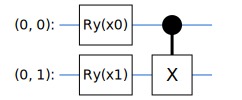

In [71]:
SVGCircuit(ttn_binary_classification_model._ttn_real_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:2')))

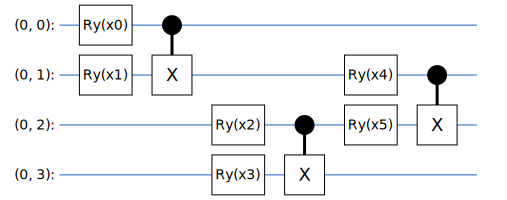

In [60]:
SVGCircuit(ttn_binary_classification_model._ttn_model_iris(cirq.GridQubit.rect(1,4))[0])

### Training

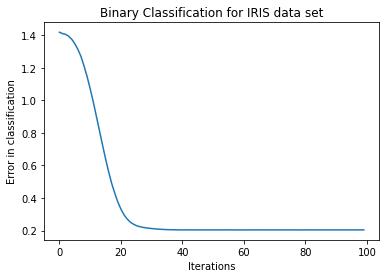

Final loss value:
0.20392305188708834


In [23]:
ttn_binary_classification_model.iris_model_fit()

In [24]:
ttn_binary_classification_model.iris_model_accuracy()

(10, 1) (10, 1)


100.0

### TTN MNIST Dataset

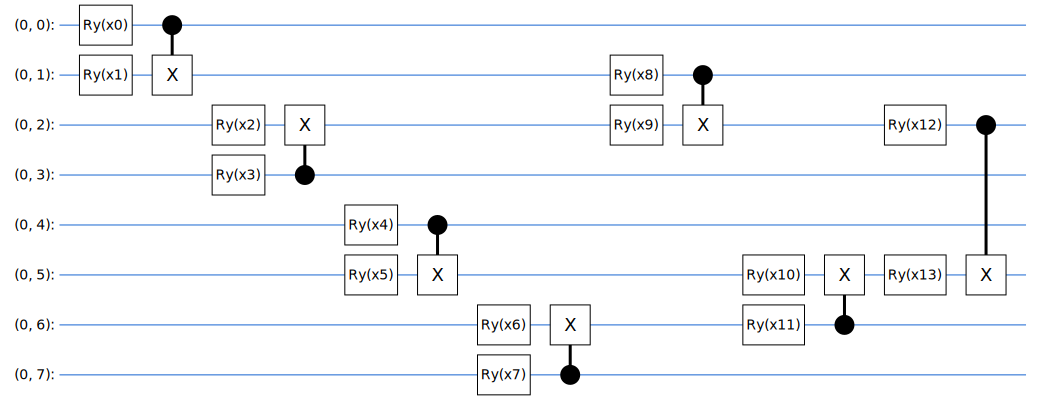

In [103]:
SVGCircuit(ttn_binary_classification_model._ttn_real_model_mnist(cirq.GridQubit.rect(1,8))[0])

Train on 13302 samples
Epoch 1/10
13302/13302 [==============================] - 58s 4ms/sample - loss: 0.7534 - _custom_accuracy: 0.7359
Epoch 2/10
13302/13302 [==============================] - 58s 4ms/sample - loss: 0.4190 - _custom_accuracy: 0.9822
Epoch 3/10
13302/13302 [==============================] - 59s 4ms/sample - loss: 0.4138 - _custom_accuracy: 0.9816
Epoch 4/10
13302/13302 [==============================] - 59s 4ms/sample - loss: 0.4113 - _custom_accuracy: 0.9830
Epoch 5/10
13302/13302 [==============================] - 58s 4ms/sample - loss: 0.4132 - _custom_accuracy: 0.9823
Epoch 6/10
13302/13302 [==============================] - 58s 4ms/sample - loss: 0.4128 - _custom_accuracy: 0.9810
Epoch 7/10
13302/13302 [==============================] - 57s 4ms/sample - loss: 0.4117 - _custom_accuracy: 0.9835
Epoch 8/10
13302/13302 [==============================] - 57s 4ms/sample - loss: 0.4113 - _custom_accuracy: 0.9837
Epoch 9/10
13302/13302 [==============================] -

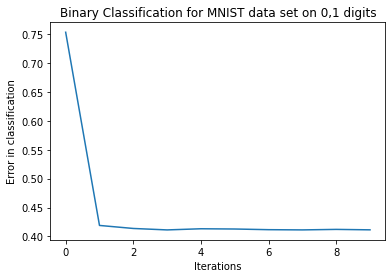

Final loss value:
0.41139821378185665


In [107]:
ttn_binary_classification_model.mnist_model_fit(epochs=10, batch_size=250, learning_rate=0.1)

In [108]:
ttn_binary_classification_model.mnist_model_accuracy()

(1478, 1) (1478, 1)


96.75236791372299

### MERA MNIST Binary Classification Data

In [114]:
class MERABinaryClassificationModel():
    def __init__(self):
        mnist_data = MNISTData()
        self.mnist_X_train, self.mnist_X_test, self.mnist_y_train, self.mnist_y_test = mnist_data.get_binary_test_train_split()
        return
    
    def _ttn_real_unitary(self, qubits, symbols, reverse=False):
        circuit = cirq.Circuit()
        circuit.append(cirq.ry(symbols[0])(qubits[0]))
        circuit.append(cirq.ry(symbols[1])(qubits[1]))
        if reverse:
            circuit.append(cirq.CNOT(qubits[1], qubits[0]))
        else:
            circuit.append(cirq.CNOT(qubits[0], qubits[1]))
        return circuit

    def _mera_real_model_mnist(self, qubits):
        symbols, circuit = sympy.symbols('x0:22'), cirq.Circuit()
        circuit.append(self._ttn_real_unitary(qubits[1:3], symbols[:2])) #D1
        circuit.append(self._ttn_real_unitary(qubits[3:5], symbols[2:4])) #D2
        circuit.append(self._ttn_real_unitary(qubits[5:7], symbols[4:6])) #D3
        
        circuit.append(self._ttn_real_unitary(qubits[:2], symbols[6:8]))   #U1
        circuit.append(self._ttn_real_unitary(qubits[2:4], symbols[8:10], reverse=True)) #U2
        circuit.append(self._ttn_real_unitary(qubits[4:6], symbols[10:12])) #U3
        circuit.append(self._ttn_real_unitary(qubits[6:8], symbols[12:14], reverse=True)) #U4
        
        circuit.append(self._ttn_real_unitary([qubits[2], qubits[5]], symbols[14:16])) #D4
        
        circuit.append(self._ttn_real_unitary(qubits[1:3], symbols[16:18])) #U5
        circuit.append(self._ttn_real_unitary(qubits[5:7], symbols[18:20], reverse=True))#U6
        
        circuit.append(self._ttn_real_unitary([qubits[2], qubits[5]], symbols[20:22]))#U7
        return circuit, symbols
    
    @tf.function
    def _custom_accuracy(self, y_true, y_pred):
        y_true = tf.squeeze(y_true)
        y_pred = tf.map_fn(lambda x: 1.0 if x >= 0.0 else -1.0, y_pred)
        return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))
    
    def _mnist_model_compile(self, learning_rate=0.1):
        cluster_state_bits = cirq.GridQubit.rect(1,8)
        readout_operators = cirq.Z(cluster_state_bits[5])
        
        mnist_ttn_model, symbols = self._mera_real_model_mnist(cluster_state_bits)
        mnist_data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
        mnist_pqc = tfq.layers.PQC(mnist_ttn_model, readout_operators, initializer=tf.keras.initializers.RandomUniform(-np.pi, np.pi))
        mnist_measurement_output = mnist_pqc(mnist_data_input)
        
        mnist_model = tf.keras.Model(inputs=mnist_data_input, outputs=mnist_measurement_output)
        mnist_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.MSE, metrics=[self._custom_accuracy])
        tf.keras.utils.plot_model(mnist_model, show_shapes=True, dpi=70)
        
        self.mnist_model = mnist_model
    
    def mnist_model_fit(self, epochs=10, learning_rate=0.1, batch_size=500):
        self._mnist_model_compile(learning_rate=learning_rate)
        history = self.mnist_model.fit(x=self.mnist_X_train, y=self.mnist_y_train, epochs=epochs, batch_size=batch_size, verbose=1)
        plt.plot(history.history['loss'])
        plt.title("Binary Classification for MNIST data set on 0,1 digits")
        plt.xlabel("Iterations")
        plt.ylabel("Error in classification")
        plt.show()
        print("Final loss value:")
        print(history.history["loss"][-1])
        
    def mnist_model_accuracy(self):
        predicted = self.mnist_model.predict(self.mnist_X_test)
        predicted[predicted >= 0] = 1.0
        predicted[predicted < 0] = -1.0
        mnist_y_test = np.expand_dims(self.mnist_y_test, axis=1)
        print(predicted.shape, mnist_y_test.shape)
        return (1-np.mean(np.abs(predicted-mnist_y_test))) * 100

In [115]:
mera_binary_classification_model = MERABinaryClassificationModel()

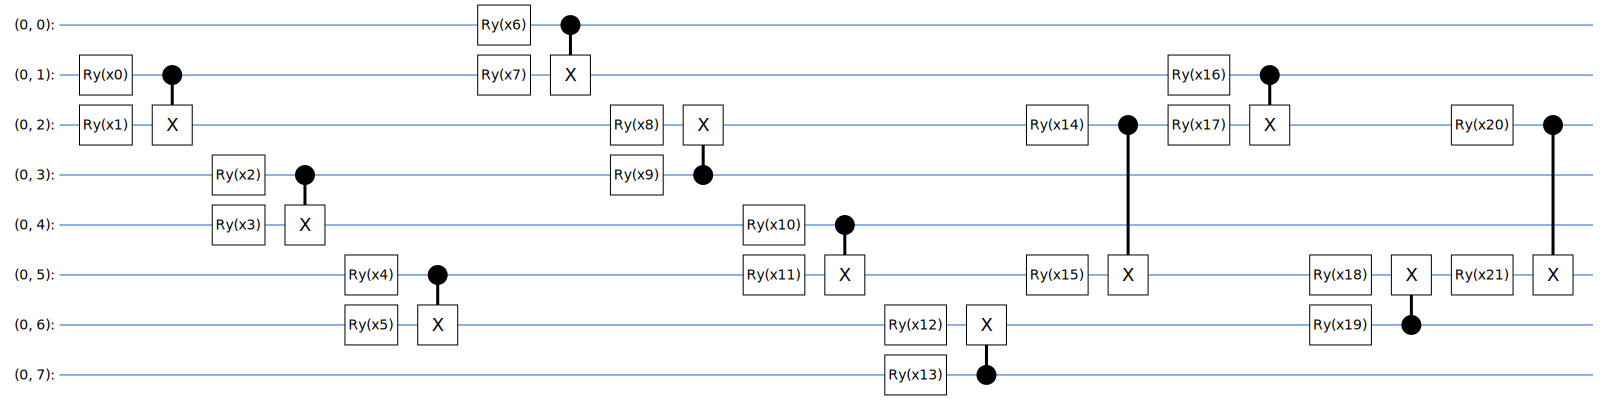

In [117]:
SVGCircuit(mera_binary_classification_model._mera_real_model_mnist(cirq.GridQubit.rect(1,8))[0])

Train on 13302 samples
Epoch 1/10
13302/13302 [==============================] - 107s 8ms/sample - loss: 0.4486 - _custom_accuracy: 0.9604
Epoch 2/10
13302/13302 [==============================] - 105s 8ms/sample - loss: 0.3954 - _custom_accuracy: 0.9823
Epoch 3/10
13302/13302 [==============================] - 105s 8ms/sample - loss: 0.3935 - _custom_accuracy: 0.9818
Epoch 4/10
13302/13302 [==============================] - 105s 8ms/sample - loss: 0.3949 - _custom_accuracy: 0.9812
Epoch 5/10
13302/13302 [==============================] - 104s 8ms/sample - loss: 0.3946 - _custom_accuracy: 0.9825
Epoch 6/10
13302/13302 [==============================] - 105s 8ms/sample - loss: 0.3928 - _custom_accuracy: 0.9820
Epoch 7/10
13302/13302 [==============================] - 104s 8ms/sample - loss: 0.3941 - _custom_accuracy: 0.9826
Epoch 8/10
13302/13302 [==============================] - 104s 8ms/sample - loss: 0.3936 - _custom_accuracy: 0.9835
Epoch 9/10
13302/13302 [=========================

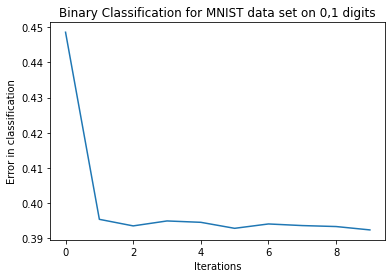

Final loss value:
0.39239121127748755


In [118]:
mera_binary_classification_model.mnist_model_fit(epochs=10, batch_size=250, learning_rate=0.1)

In [119]:
mera_binary_classification_model.mnist_model_accuracy()

(1478, 1) (1478, 1)


97.97023013234138

### References:

1. Grant, E., Benedetti, M., Cao, S., Hallam, A., Lockhart, J., Stojevic, V., Green, A.G. and Severini, S., 2018. Hierarchical quantum classifiers. npj Quantum Information, 4(1), pp.1-8.

2. LeCun, Y., Cortes, C. & Burges, C. J. C.The  MNIST  Database  of  Handwritten  Digits(1998).http://yann.lecun.com/exdb/mnist

3. Fisher, R. A. The use of multiple measurements in taxonomic problems.Ann. Hum.Genet.7, 179–188 (1936)

4. Vartiainen, J.J., Möttönen, M. and Salomaa, M.M., 2004. Efficient decomposition of quantum gates. Physical review letters, 92(17), p.177902.